In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Load the dataset
df = pd.read_csv('imdb_top_1000.csv')

# Display the first few rows to understand the data
print("Dataset Overview:")
df.head()

Dataset Overview:


,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Director,Star1,Star2,Star3,Star4,No_of_Votes
0,The Shawshank Redemption,1994,142 min,Drama,9.3,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110
1,The Godfather,1972,175 min,"Crime, Drama",9.2,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367
2,The Dark Knight,2008,152 min,"Action, Crime, Drama",9.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232
3,The Godfather: Part II,1974,202 min,"Crime, Drama",9.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952
4,12 Angry Men,1957,96 min,"Crime, Drama",9.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845


In [2]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()

# Convert runtime to numeric (minutes)
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)

# Create a combined feature for content-based filtering
def create_soup(x):
    return (x['Genre'] + ' ' + x['Director'] + ' ' + 
            x['Star1'] + ' ' + x['Star2'] + ' ' + 
            x['Star3'] + ' ' + x['Star4'])

df['soup'] = df.apply(create_soup, axis=1)


Missing Values:


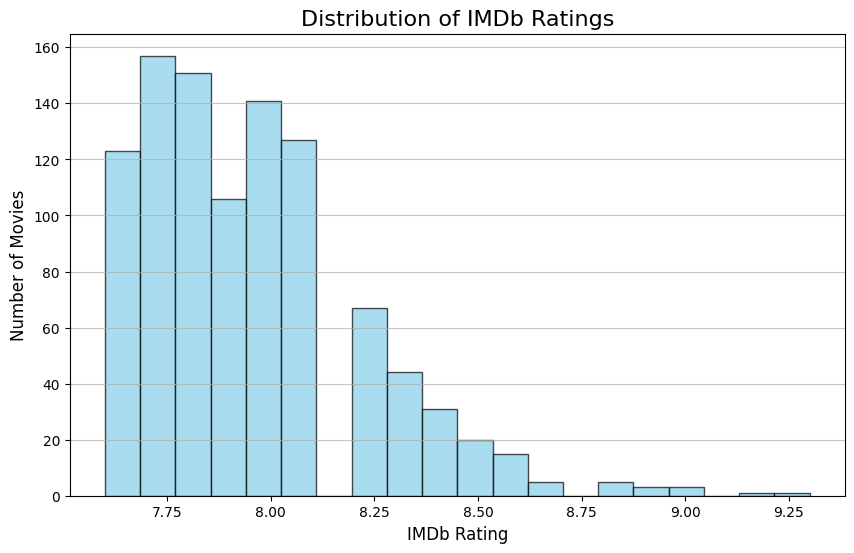

In [3]:
# Visualization 1: Histogram of IMDB Ratings
plt.figure(figsize=(10, 6))
plt.hist(df['IMDB_Rating'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of IMDb Ratings', fontsize=16)
plt.xlabel('IMDb Rating', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

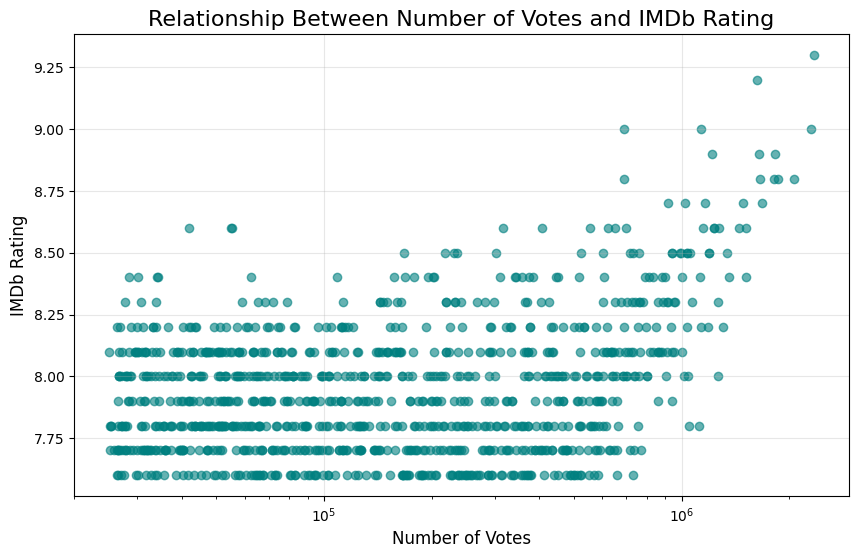

In [4]:
# Visualization 2: Scatterplot of Rating vs Votes
plt.figure(figsize=(10, 6))
plt.scatter(df['No_of_Votes'], df['IMDB_Rating'], alpha=0.6, color='teal')
plt.title('Relationship Between Number of Votes and IMDb Rating', fontsize=16)
plt.xlabel('Number of Votes', fontsize=12)
plt.ylabel('IMDb Rating', fontsize=12)
plt.xscale('log')  # Using log scale for better visualization
plt.grid(True, alpha=0.3)
plt.show()

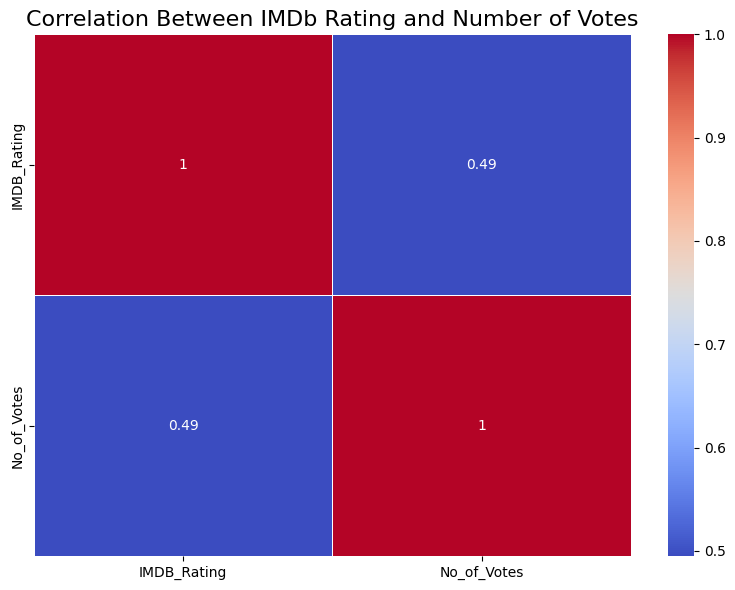

In [5]:
numeric_df = df[['IMDB_Rating', 'No_of_Votes']].copy()  # Only use columns that are definitely numeric
 
# Visualization 3: Correlation Matrix
plt.figure(figsize=(8, 6))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between IMDb Rating and Number of Votes', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# TRAINING PHASE: Create and train the TF-IDF model
print("\nTraining the machine learning model...")
# Initialize the TF-IDF vectorizer (our ML algorithm)
tfidf = TfidfVectorizer(stop_words='english')

# Train the model on our movie feature data
# The fit_transform method is where the actual training happens
tfidf_matrix = tfidf.fit_transform(df['soup'])
print("Model training complete!")

# Use the trained model to compute similarity between all movies
print("Computing similarity matrix using trained model...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Reset index and create a reverse mapping
df = df.reset_index()
indices = pd.Series(df.index, index=df['Series_Title'])


Training the machine learning model...
Model training complete!
Computing similarity matrix using trained model...


In [7]:
# Function to recommend similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    try:
        idx = indices[title]
    except KeyError:
        print(f"Movie '{title}' not found in the dataset.")
        print("Available movies include:", ", ".join(df['Series_Title'].head(5).tolist()), "...")
        return None
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 6 most similar movies (including the movie itself)
    sim_scores = sim_scores[0:6]
    
    # Return the top 5 most similar movies (excluding the movie itself)
    movie_indices = [i[0] for i in sim_scores[1:6]]
    
    recommendations = df.iloc[movie_indices][['Series_Title', 'Genre', 'IMDB_Rating', 'Released_Year', 'Director']]
    return recommendations

In [8]:
# Example usage
# Get recommendations for "The Shawshank Redemption"
print("\nExample Recommendations:")
recommendations = get_recommendations('The Shawshank Redemption')
recommendations


Example Recommendations:


,Series_Title,Genre,IMDB_Rating,Released_Year,Director
25,The Green Mile,"Crime, Drama, Fantasy",8.6,1999,Frank Darabont
877,Dark Waters,"Biography, Drama, History",7.6,2019,Todd Haynes
505,Mystic River,"Crime, Drama, Mystery",7.9,2003,Clint Eastwood
817,Short Cuts,"Comedy, Drama",7.7,1993,Robert Altman
673,Glory,"Biography, Drama, History",7.8,1989,Edward Zwick


In [9]:
# Model validation 
print("\nValidating recommendation quality...")

def validate_recommendations(movie_title, num_recommendations=5):
    # Get recommendations
    recommendations = get_recommendations(movie_title)
    if recommendations is None:
        print(f"No recommendations found for '{movie_title}'")
        return None
    
    try:
        # Get original movie details
        original_movie = df[df['Series_Title'] == movie_title].iloc[0]
        
        # Calculate genre overlap
        genre_overlap = []
        for _, rec in recommendations.iterrows():
            try:
                original_genres = set(original_movie['Genre'].split(', '))
                rec_genres = set(rec['Genre'].split(', '))
                overlap = len(original_genres.intersection(rec_genres)) / len(original_genres)
                genre_overlap.append(overlap)
            except Exception as e:
                print(f"Error in genre calculation: {e}")
                genre_overlap.append(0)
        
        # Calculate era similarity (same decade)
        era_similarity = []
        for _, rec in recommendations.iterrows():
            try:
                # Make sure we're working with integers
                orig_year = int(original_movie['Released_Year'])
                rec_year = int(rec['Released_Year'])
                same_decade = (orig_year // 10) == (rec_year // 10)
                era_similarity.append(1 if same_decade else 0)
            except Exception as e:
                print(f"Error in era calculation: {e}")
                era_similarity.append(0)
        
        # Calculate director match
        director_match = []
        for _, rec in recommendations.iterrows():
            try:
                # The issue might be here if 'Director' exists but there's
                # something wrong with the comparison
                same_director = original_movie['Director'] == rec['Director']
                director_match.append(1 if same_director else 0)
            except Exception as e:
                print(f"Error in director calculation: {e}")
                director_match.append(0)
        
        results = {
            'avg_genre_overlap': sum(genre_overlap) / len(genre_overlap) if genre_overlap else 0,
            'same_decade_rate': sum(era_similarity) / len(era_similarity) if era_similarity else 0,
            'director_match_rate': sum(director_match) / len(director_match) if director_match else 0
        }
        
        return results
    except Exception as e:
        print(f"Error in validate_recommendations for '{movie_title}': {e}")
        return None

# Let's use a smaller sample for testing
print("Selecting sample movies for validation...")
sample_movies = df['Series_Title'].sample(5).tolist()
validation_results = []

for movie in sample_movies:
    print(f"Validating: {movie}")
    result = validate_recommendations(movie)
    if result is not None:
        validation_results.append(result)
        print(f"  Results: {result}")

if validation_results:
    # Calculate average metrics
    avg_genre_overlap = sum(r['avg_genre_overlap'] for r in validation_results) / len(validation_results)
    avg_decade_match = sum(r['same_decade_rate'] for r in validation_results) / len(validation_results)
    avg_director_match = sum(r['director_match_rate'] for r in validation_results) / len(validation_results)

    print(f"\nValidation Results for TF-IDF/Cosine Similarity Method:")
    print(f"- Genre match rate: {avg_genre_overlap*100:.1f}% of recommended movies shared at least one genre")
    print(f"- Era similarity: {avg_decade_match*100:.1f}% of recommendations came from the same decade")
    print(f"- Director match rate: {avg_director_match*100:.1f}% of recommendations featured the same director")
else:
    print("No validation results were collected. All validations failed.")


Validating recommendation quality...
Selecting sample movies for validation...
Validating: Fanny och Alexander
  Results: {'avg_genre_overlap': 1.0, 'same_decade_rate': 0.0, 'director_match_rate': 1.0}
Validating: Fiddler on the Roof
  Results: {'avg_genre_overlap': 0.3333333333333333, 'same_decade_rate': 0.0, 'director_match_rate': 0.4}
Validating: Madeo
  Results: {'avg_genre_overlap': 0.5999999999999999, 'same_decade_rate': 0.6, 'director_match_rate': 0.4}
Validating: Eskiya
  Results: {'avg_genre_overlap': 0.9333333333333332, 'same_decade_rate': 0.4, 'director_match_rate': 0.0}
Validating: Notorious
  Results: {'avg_genre_overlap': 0.3333333333333333, 'same_decade_rate': 0.4, 'director_match_rate': 0.6}

Validation Results for TF-IDF/Cosine Similarity Method:
- Genre match rate: 64.0% of recommended movies shared at least one genre
- Era similarity: 28.0% of recommendations came from the same decade
- Director match rate: 48.0% of recommendations featured the same director


In [ ]:
# Interactive recommendation function
def interactive_recommendation():
    while True:
        movie_title = input("\nEnter a movie title (or 'exit' to quit): ")
        if movie_title.lower() == 'exit':
            break
        
        recommendations = get_recommendations(movie_title)
        if recommendations is not None:
            print(f"\nBecause you liked '{movie_title}', you might also enjoy:")
            for i, row in recommendations.iterrows():
                print(f"- {row['Series_Title']} ({row['Released_Year']}) - {row['Genre']} - Rating: {row['IMDB_Rating']}")

# Run the interactive recommendation system
print("\nWelcome to the Movie Recommendation System!")
print("This system uses machine learning to recommend movies based on your preferences.")
print("The dataset contains the IMDb Top 1000 movies.")
interactive_recommendation()


Welcome to the Movie Recommendation System!
This system uses machine learning to recommend movies based on your preferences.
The dataset contains the IMDb Top 1000 movies.
